In [427]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from random import randint

plt.style.use(["Solarize_Light2"])
plt.rcParams["axes.edgecolor"] = "#66818c"
plt.rcParams["axes.facecolor"] = "#263238"
plt.rcParams["figure.facecolor"] = "#263238"
plt.rcParams["grid.color"] = "#3f575b"
plt.rcParams["xtick.color"] = "#bfd5dd"
plt.rcParams["ytick.color"] = "#bfd5dd"
plt.rcParams["text.color"] = "#bfd5dd"
plt.rcParams["axes.labelcolor"] = "#bfd5dd"

engine = create_engine("postgresql+psycopg2://{}:{}@{}:{}/{}".format())

In [428]:
query = """ SELECT area,
                   area_kitchen,
                   area_living,
                   price
            FROM flat
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df = df[(df.area_kitchen < 4e+1)]
df.drop("price", axis=True, inplace=True)

df = df[~df.area_living.isnull()]
df = (df-df.min())/(df.max()-df.min())
X = df.drop("area_kitchen", axis=True).values
y = df["area_kitchen"].values

epoch = 40000
step = .005
w = [0] * X.shape[1]
for _ in range(epoch):
    i = randint(0, X.shape[0]-1)
    w -= step * 2 * (X[i].dot(w)-y[i]) * X[i]
w

array([1.68006287, 0.93524334, 1.53045991])

In [429]:
query = """ SELECT area,
                   price,
                   street
            FROM flat
            INNER JOIN building ON building_id = building.id
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df = df.groupby("street").ppm.mean()
streets = df[df > 4e+05].index
streets

Index(['1-й Волконский переулок', '1-й Зачатьевский переулок',
       '1-й Колобовский переулок', '1-й Красногвардейский проезд',
       '1-й Неопалимовский переулок', '1-й Обыденский переулок',
       '1-й Смоленский переулок', '1-й Спасоналивковский переулок',
       '1-й Тверской-Ямской переулок', '2-й Зачатьевский переулок',
       ...
       'улица Сергея Макеева', 'улица Советской Армии', 'улица Солянка',
       'улица Спиридоновка', 'улица Трехгорный Вал', 'улица Улофа Пальме',
       'улица Усачева', 'улица Фадеева', 'улица Фотиевой', 'улица Чаянова'],
      dtype='object', name='street', length=244)

In [430]:
table_name = "flat"
query = """ SELECT owner_type,
                   area,
                   area_kitchen,
                   area_living,
                   floor,
                   rooms,
                   layout,
                   height,
                   bathrooms,
                   window_types,
                   balconies,
                   condition,
                   price,
                   type,
                   year,
                   material,
                   floors,
                   garbage_chute,
                   heating_type,
                   district,
                   lng,
                   lat,
                   street
            FROM {}
            INNER JOIN building ON flat.building_id = building.id
            WHERE district > -1
        """.format(table_name)
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df.drop("price", axis=True, inplace=True)
df.loc[:, "window_0"] = df.window_types.apply(lambda i: None if i is None else i[0])
df.loc[:, "window_1"] = df.window_types.apply(lambda i: None if i is None else i[1])
df[["window_1", "window_0"]] = df[["window_1", "window_0"]].fillna(0)
df.drop("window_types", axis=True, inplace=True)
df.loc[:, "bathrooms_0"] = df.bathrooms.apply(lambda i: None if i is None else i[0])
df.loc[:, "bathrooms_1"] = df.bathrooms.apply(lambda i: None if i is None else i[1])
df[["bathrooms_0", "bathrooms_1"]] = df[["bathrooms_0", "bathrooms_1"]].fillna(0)
df.drop("bathrooms", axis=True, inplace=True)
df.loc[:, "balconies_0"] = df.balconies.apply(lambda i: None if i is None else i[0])
df.loc[:, "balconies_1"] = df.balconies.apply(lambda i: None if i is None else i[1])
df[["balconies_0", "balconies_1"]] = df[["balconies_0", "balconies_1"]].fillna(0)
df.drop("balconies", axis=True, inplace=True)
df.loc[~df.garbage_chute.isnull() & df.garbage_chute, "garbage_chute_1"] = 1
df.loc[~df.garbage_chute.isnull() & df.garbage_chute == False, "garbage_chute_0"] = 1
df.loc[:, "garbage_chute_0"] = df.loc[:, "garbage_chute_0"].fillna(0)
df.loc[:, "garbage_chute_1"] = df.loc[:, "garbage_chute_1"].fillna(0)
df.drop("garbage_chute", axis=True, inplace=True)
for i in df.type.unique():
    if i >= .0:
        df.loc[df.type == i, "type_"+str(i)] = 1
        df.loc[:, "type_"+str(i)] = df.loc[:, "type_"+str(i)].fillna(0)
df.drop("type", axis=True, inplace=True)
for i in df.layout.unique():
    if i >= .0:
        df.loc[df.layout == i, "layout_"+str(i)] = 1
        df.loc[:, "layout_"+str(i)] = df.loc[:, "layout_"+str(i)].fillna(0)
df.drop("layout", axis=True, inplace=True)
for i in df.material.unique():
    if i >= .0:
        df.loc[df.material == i, "material_"+str(i)] = 1
        df.loc[:, "material_"+str(i)] = df.loc[:, "material_"+str(i)].fillna(0)
df.drop("material", axis=True, inplace=True)
for i in df.condition.unique():
    if i >= .0:
        df.loc[df.condition == i, "condition_"+str(i)] = 1
        df.loc[:, "condition_"+str(i)] = df.loc[:, "condition_"+str(i)].fillna(0)
df.drop("condition", axis=True, inplace=True)
for i in df.heating_type.unique():
    if i >= .0:
        df.loc[df.heating_type == i, "heating_type_"+str(i)] = 1
        df.loc[:, "heating_type_"+str(i)] = df.loc[:, "heating_type_"+str(i)].fillna(0)
df.drop("heating_type", axis=True, inplace=True)
for i in df.owner_type.unique():
    if i >= .0:
        df.loc[df.owner_type == i, "owner_type_"+str(i)] = 1
        df.loc[:, "owner_type_"+str(i)] = df.loc[:, "owner_type_"+str(i)].fillna(0)
df.drop("owner_type", axis=True, inplace=True)

for i in df.district.unique():
    if i >= .0:
        df.loc[df.district == i, "district_"+str(i)] = 1
        df.loc[:, "district_"+str(i)] = df.loc[:, "district_"+str(i)].fillna(0)
df.drop("district", axis=True, inplace=True)
df.loc[:, "l1"] = df.street.isin(streets)
df.drop("street", axis=True, inplace=True)
df.shape

(26545, 56)

In [8]:
df[df.area_kitchen.isnull()].shape

(5696, 56)

In [431]:
for i in df.loc[df.area_kitchen.isnull() & ~df.area_living.isnull()].index:
    X = df.loc[i, ["area", "area_living", "ppm"]]
    X = ((X-X.min())/(X.max()-X.min())).values
    a = X.dot(w)
    if a > df.loc[:, "area_kitchen"].mean():
        df.loc[i, "area_kitchen"] = a - df.loc[:, "area_kitchen"].std()
    else:
        df.loc[i, "area_kitchen"] = a + df.loc[:, "area_kitchen"].std()

In [10]:
df[df.area_kitchen.isnull()].shape

(4434, 56)

In [15]:
df[df.height.isnull()].shape

(13496, 56)

In [432]:
for x in [x for x in df.columns if "material_" in x]:
    m = df[df[x] == 1].height.median()
    df.loc[df[x] == 1, "height"] = df.loc[df[x] == 1, "height"].fillna(m)

In [17]:
df[df.height.isnull()].shape

(3165, 56)

In [433]:
df = df[(df.ppm >= 80000) & (df.ppm < 1000000) & (df.height > 2.4) & (df.height < 4.9) & ~df.area_kitchen.isnull() & ~df.area_living.isnull() & (df.floor!=69) & (df.year > 1000)]
df.loc[:, "floorgr17"] = (df.floor < 17) & (df.floor != 50) & (df.floor != 55)
df.floorgr17 = df.floorgr17.astype(int)
df.loc[:, "byless1944"] = df.year < 1944
df.byless1944 = df.byless1944.astype(int)
df.loc[:, "ff"] = df.floors / df.floor
df.loc[:, "aa"] = df.area > 1.5*df.area.mean()
df.loc[:, "aa2"] = df.area_living > df.area_living.mean()
df.loc[:, "aa3"] = df.floors > .5*df.floors.median()
df.loc[:, "aa4"] = df.height > 1.4*df.height.mean()
df.loc[:, "aa5"] = df.bathrooms_0 > df.bathrooms_0.mean()
df.loc[:, "aa6"] = df.bathrooms_1 > df.bathrooms_1.mean()
df.loc[:, "aa7"] = (df.bathrooms_0 + df.bathrooms_1) > (df.bathrooms_0 + df.bathrooms_1).mean()
df.loc[:, "aa8"] = df.rooms > df.rooms.median()
df.loc[:, "aa9"] = df.area_kitchen//10 == 0
df.loc[:, "aa10"] = df.floor//10 == 0
df.loc[:, "aa11"] = df.floors//10 > 1
df.loc[:, "d1"] = ((df.lng - 37.59565428999999)**2 + (df.lat-55.74813359000001)**2)**.5
df.loc[:, "d2"] = df.d1 < .1
df.shape

(18945, 72)

In [434]:
cost = lambda y_, y: 1/len(y) * sum((y_-y)**2)

In [435]:
columns = [
#     'layout_0.0',
#     'heating_type_1.0',
#     'condition_2.0',
#     'material_7.0',
#     'material_1.0',
#     'layout_2.0',
#     'layout_1.0',
#     'balconies_1',
#     'window_0',
#     'year',
#     'window_1',
#     'balconies_0',
#     'owner_type_0.0',
#     'heating_type_0.0',
#     'heating_type_2.0',
#     'floors',
#     'material_4.0',
#     'garbage_chute_1',
#     'garbage_chute_0',
#     'heating_type_3.0',
#     'owner_type_2.0',
#     'condition_0.0',
#     'material_0.0',
#     'type_1.0',
#     'owner_type_1.0',
#     'type_0.0',
#     'floor',
#     'material_2.0',
#     'owner_type_3.0',
#     'bathrooms_1',
#     'condition_1.0',
#     'material_6.0',
#     'rooms',
#     'material_3.0',
#     'area_kitchen',
#     'bathrooms_0',
#     'condition_3.0',
#     'area_living',
#     'area',
#     'height',
    'ppm',
    'lng',
    'lat'
]
X = df.drop(columns, axis=True)
y = df.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values

epoch = 20000
step = 100
w = [0] * X.shape[1]
errs = []
for e in range(epoch):
    s = X.shape[0]
    i = randint(0, s-1)
    w -= (step/(s+50*e) * (X[i].dot(w)-y[i])) * (X[i] + np.linalg.norm(w))
    errs.append(cost(X[0:100].dot(w), y[0:100]))
w

array([ 0.0116698 ,  0.01583306,  0.05011192,  0.07864442, -0.04724202,
        0.1186894 ,  0.11190103, -0.0713402 , -0.01736476, -0.02363816,
        0.01454695,  0.01323442, -0.02178723, -0.03389185,  0.07715873,
        0.07949578,  0.08855149,  0.06772621, -0.02305744,  0.01668487,
       -0.00233487,  0.03253264,  0.0496973 ,  0.01246018,  0.03668175,
        0.02208113,  0.00132398,  0.01335075,  0.01476598,  0.13607163,
        0.05540669,  0.08848215, -0.01818147,  0.02310057,  0.00946242,
        0.0070569 ,  0.0096904 , -0.00121877,  0.0027413 , -0.00446352,
        0.21574553, -0.00558331,  0.02564017,  0.07889507,  0.05488999,
        0.10145406,  0.10402411,  0.05057928,  0.12315881,  0.06745849,
        0.02034827,  0.05153004,  0.39922992,  0.01527494, -0.02506744,
       -0.02407442,  0.06706471, -0.00101007,  0.0095242 , -0.03005492,
       -0.01097771, -0.05360883, -0.00291376, -0.02364697,  0.04029173,
        0.02337858,  0.0117745 , -0.20353901,  0.11586182])

In [436]:
plt.figure(figsize=(16, 9))
plt.scatter(range(len(errs)), errs)

In [437]:
sum((X.dot(w)-y)**2)/len(y)

0.25684708209751056

In [438]:
fig, plts = plt.subplots(nrows=11, ncols=1, figsize=(30, 50))

plts[10].scatter(range(len(y)), y, s=25, alpha=.1)
plts[10].scatter(range(len(y)), X.dot(w), s=15, c="y", alpha=.1)

plts[0].scatter(range(2000), y[:2000], s=25)
plts[0].scatter(range(2000), X.dot(w)[:2000], s=10, c="y")
plts[1].scatter(range(2000), y[2000:4000], s=25)
plts[1].scatter(range(2000), X.dot(w)[2000:4000], s=10, c="y")
plts[2].scatter(range(2000), y[4000:6000], s=25)
plts[2].scatter(range(2000), X.dot(w)[4000:6000], s=10, c="y")
plts[3].scatter(range(2000), y[6000:8000], s=25)
plts[3].scatter(range(2000), X.dot(w)[6000:8000], s=10, c="y")
plts[4].scatter(range(2000), y[8000:10000], s=25)
plts[4].scatter(range(2000), X.dot(w)[8000:10000], s=10, c="y")
plts[5].scatter(range(2000), y[10000:12000], s=25)
plts[5].scatter(range(2000), X.dot(w)[10000:12000], s=10, c="y")
plts[6].scatter(range(2000), y[12000:14000], s=25)
plts[6].scatter(range(2000), X.dot(w)[12000:14000], s=10, c="y")
plts[7].scatter(range(2000), y[14000:16000], s=25)
plts[7].scatter(range(2000), X.dot(w)[14000:16000], s=10, c="y")
plts[8].scatter(range(2000), y[16000:18000], s=25)
plts[8].scatter(range(2000), X.dot(w)[16000:18000], s=10, c="y")

plts[9].scatter(range(len(y[18000:])), y[18000:], s=25)
plts[9].scatter(range(len(y[18000:])), X.dot(w)[18000:], s=10, c="y");

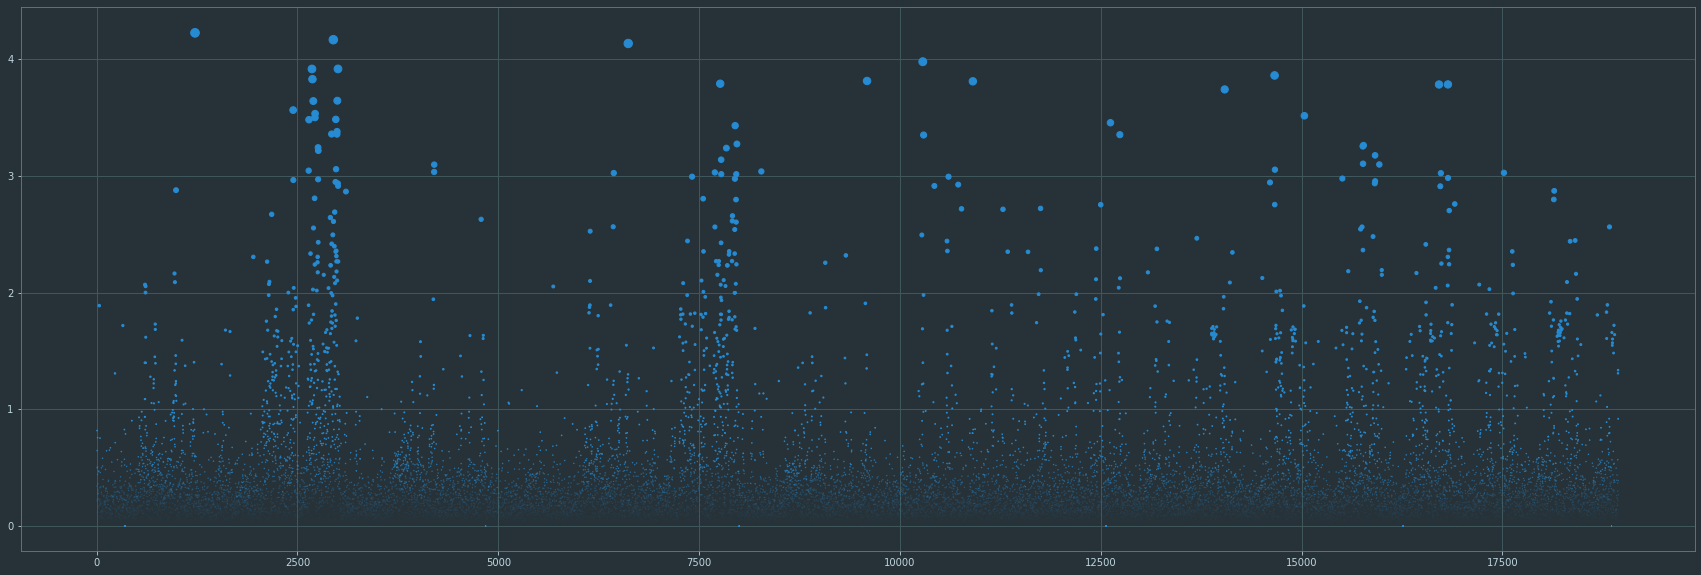

In [439]:
# print(np.median(y), y.std())
plt.figure(figsize=(30, 10))
y_ = ((y-X.dot(w))**2)**.5
plt.scatter(range(len(y_)), y_, s=y_**3);

In [419]:
len(list(filter(lambda x: x>1, ((y-X.dot(w))**2)**.5)))

1062

In [420]:
np.mean(((y-X.dot(w))**2)**.5)

0.31306563506859336

In [421]:
plt.figure(figsize=(10, 10))
plt.scatter(y, X.dot(w), s=1);